In [3]:
clear
addpath('/home/amplifier/home/MATLAB')
addpath('/home/amplifier/home/DATASETS')
load('all.mat')
close all

In [12]:
load('a.mat')
load('scores.mat')
load('lookup_tab.mat')

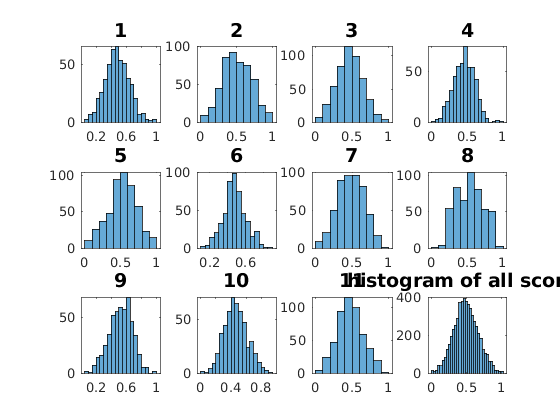

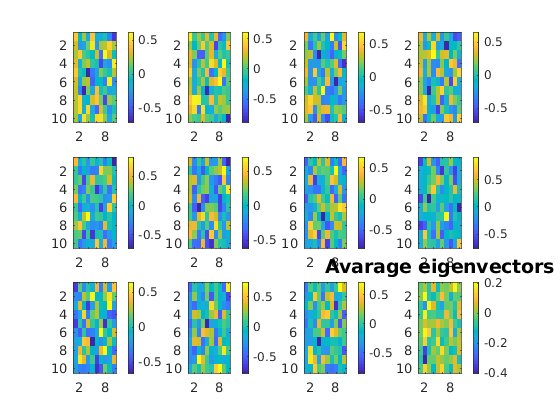

In [15]:
% RUN THIS CELL IF YOU WANT PROJECTED SCORES. IF YOU WANT STRAIGHT SCORES, SKIP IT

load('/home/amplifier/home/MATLAB/a.mat')
load('/home/amplifier/home/MATLAB/scores.mat')
load('/home/amplifier/home/MATLAB/lookup_tab.mat')

%%
eig_of_interest = 2;
g = [];
scores_tmp = [];
U = [];
all_scores = [];
for i = 1:11
    scores_tmp = eval(lookup_tab{i,2});
    all_scores = cat(2, all_scores, scores_tmp);
    [U(:,:,i),~,~] = svd(scores_tmp);
end

% fix the eigs:
flip_eigs = [1, 2, 3, 4, 5, 6];
U(:,:,flip_eigs) = U(:,:,flip_eigs) * (-1);

U_m = squeeze(mean(U,3));

figure
for i = 1:11
    subplot(3,4,i)
    imagesc(squeeze(U(:,:,i))); colorbar;
end

U_m = U_m * (-1);
subplot(3,4,12)
imagesc(U_m); colorbar
tit = title('Avarage eigenvectors');
tit.FontSize = 14;

% project and normalize the scores:

sc = mapminmax(U_m'* all_scores, 0,1);
qq = quantile(sc, [0.33 0.66]);

figure
dsp = 0;
for i = 1:11
    sc_tmp = sc(:,1+dsp:50+dsp);
    assignin('base', lookup_tab{i,2}, sc_tmp);
    subplot(3,4,i)
    histogram(sc_tmp); 
    tit = title(num2str(i));
    tit.FontSize = 14;
    dsp = dsp + 50;
end

subplot(3,4,12)
histogram(sc);
tit = title('histogram of all scores');
tit.FontSize = 14;

In [13]:
% [EEG.event.dataset] = deal([]);
% [EEG.event.dataset] = deal(EEG.comments);


% perform some string transformation (dataset names):
for i = 1:length({EEG.event.dataset})
    EEG.event(i).dataset = erase(EEG.event(i).dataset, 'Original file: ');
    EEG.event(i).dataset = erase(EEG.event(i).dataset, '.eeg');
end


% enter score file names for each epoch:
clc
for i = 1:length({EEG.event.dataset})
    ds_name = EEG.event(i).dataset;
    if strcmp(ds_name, '') == 0
        ds_find_idx = find(ismember({lookup_tab{:,1}}, ds_name));
        EEG.event(i).sc = lookup_tab{ds_find_idx,2};
    else
%         disp(i)
    end
end

% add responses for each epoch:

for i = 1:length({EEG.event.dataset})
    if      (strcmp(EEG.event(i).type, 'boundary') == 1 ||...
            strcmp(EEG.event(i).type, 'Nachalo audio') == 1 ||...
            strcmp(EEG.event(i).type, 'a') == 1 ||...
            strcmp(EEG.event(i).type, 'empty') == 1 ||...
            strcmp(EEG.event(i).type, 'A') == 1 ||...
            strcmp(EEG.event(i).type, 'Bip') == 1) == 0
        EEG.event(i).response1 = eval([EEG.event(i).sc, '(1,', EEG.event(i).type, ')']);
        EEG.event(i).response1 = eval([EEG.event(i).sc, '(:,', EEG.event(i).type, ')']);
    else
        EEG.event(i).response1 = nan(10,1);
    end
end

ERP 1
alpha 1
ERP 2
alpha 2
ERP 3
alpha 3
ERP 4
original latency 145  170
ampl. at latencies 3.8365      3.3235
returned latency145
alpha 4
ERP 5
alpha 5
ERP 6
alpha 6
ERP 7
original latency 145  170
ampl. at latencies 2.9067      2.7863
returned latency145
alpha 7
ERP 8
original latency 150  170
ampl. at latencies 3.4778      3.2775
returned latency150
alpha 8
ERP 9
alpha 9
ERP 10
alpha 10


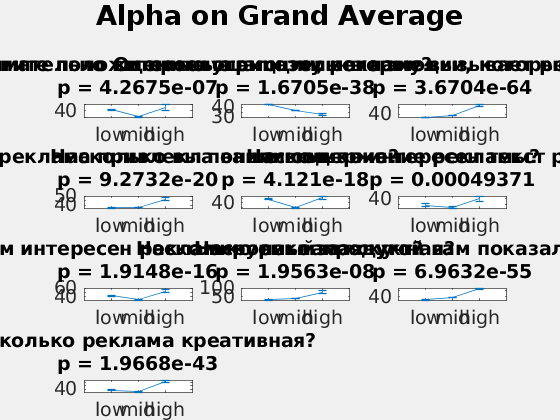

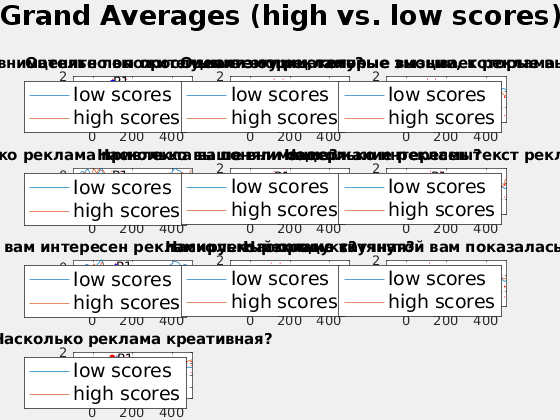

In [14]:
%% Grand Averages

chan = 64; % 17 for Cz or 64 for a virtual channel (projection of the 63 real channels)

f = figure('units','normalized','outerposition',[0 0 1 1]);
p = uipanel('Parent',f,'BorderType','none'); 
p.Title = 'Grand Averages (high vs. low scores)'; 
p.TitlePosition = 'centertop'; 
p.FontSize = 20;    
p.FontWeight = 'bold';

f1 = figure('units','normalized','outerposition',[0 0 1 1]);
p1 = uipanel('Parent',f1,'BorderType','none'); 
p1.Title = 'Alpha on Grand Average'; 
p1.TitlePosition = 'centertop'; 
p1.FontSize = 20;    
p1.FontWeight = 'bold';

% to use projected scores, run SCORES_EIG.m first then run BLOCK_2
% otherwise load('scores.mat')

responses = [EEG.event.response1]';
tab = struct;

for k = 1:10
    quant = [0.25 0.75];
    var_of_interest = k;
   
    lo_co = quantile(responses(:, var_of_interest), quant(1));
    hi_co = quantile(responses(:, var_of_interest), quant(2));
    
    LO_idx = find(responses(:,var_of_interest) <= lo_co);
    HI_idx = find(responses(:,var_of_interest) >= hi_co);
    MID_idx = find(not(responses(:,var_of_interest) <= lo_co) &...
        not(responses(:,var_of_interest) >= hi_co));

    lat_lo = [EEG.event(LO_idx).latency];
    lat_hi = [EEG.event(HI_idx).latency];
    lat_mid = [EEG.event(MID_idx).latency];
    
    X_lo = ERPs_1(EEG, lat_lo);
    X_hi = ERPs_1(EEG, lat_hi);
    X_mid = ERPs_1(EEG, lat_mid);

    X_lo_GA = squeeze(mean(X_lo,1));
    X_hi_GA = squeeze(mean(X_hi,1));
    X_mid_GA = squeeze(mean(X_mid,1));


    t = linspace(-100, 500, 121);
    set(0, 'CurrentFigure', f)
    disp(['ERP ', num2str(k)])
    [tab] = plot_single_stat(X_lo_GA, X_hi_GA, X_lo, X_hi, t, k, p, tab, chan, 0);

    tit = title(a(var_of_interest));
    tit.FontSize = 11;
    leg = legend({'low scores', 'high scores'});
    leg.FontSize = 14;
    
    set(0, 'CurrentFigure', f1)
    get_alpha(EEG, X_lo, X_hi, X_mid, k, p1, a, chan, 0);
    disp(['alpha ', num2str(k)])
end

saveas(f,'/home/amplifier/home/MATLAB/test0.fig')
saveas(f1,'/home/amplifier/home/MATLAB/test1.fig')
save('tab.mat', 'tab')


k =

     2

ERP 2
alpha 2


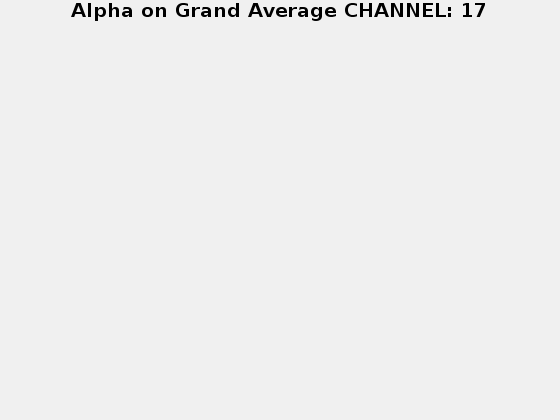

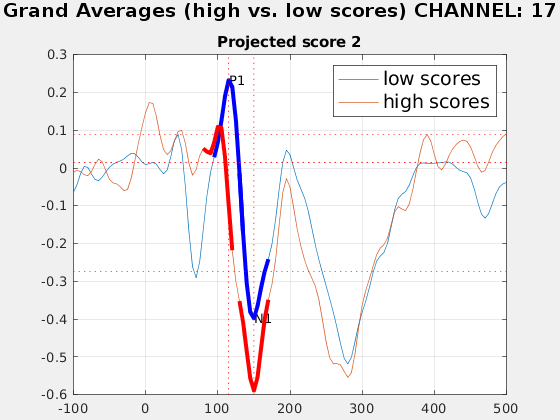

In [16]:
%% SAME BUT ON PROJECTED SCORES

chan = 17; %chan = 17; % 17 for Cz or 64 for a virtual channel (projection of the 63 real channels)

% component on which to project
k = 2

f = figure('units','normalized','outerposition',[0 0 1 1]);
p = uipanel('Parent',f,'BorderType','none'); 
p.Title = ['Grand Averages (high vs. low scores) ', 'CHANNEL: ', num2str(chan)]; 
p.TitlePosition = 'centertop'; 
p.FontSize = 14;    
p.FontWeight = 'bold';

f1 = figure('units','normalized','outerposition',[0 0 1 1]);
p1 = uipanel('Parent',f1,'BorderType','none'); 
p1.Title = ['Alpha on Grand Average ', 'CHANNEL: ', num2str(chan)]; 
p1.TitlePosition = 'centertop'; 
p1.FontSize = 14;    
p1.FontWeight = 'bold';

% to use projected scores, run SCORES_EIG.m first then run BLOCK_2
% otherwise load('scores.mat')

responses = [EEG.event.response1]';
tab = struct;


    quant = [0.25 0.75];
    var_of_interest = k;
   
    lo_co = quantile(responses(:, var_of_interest), quant(1));
    hi_co = quantile(responses(:, var_of_interest), quant(2));
    
    LO_idx = find(responses(:,var_of_interest) <= lo_co);
    HI_idx = find(responses(:,var_of_interest) >= hi_co);
    MID_idx = find(not(responses(:,var_of_interest) <= lo_co) &...
        not(responses(:,var_of_interest) >= hi_co));

    lat_lo = [EEG.event(LO_idx).latency];
    lat_hi = [EEG.event(HI_idx).latency];
    lat_mid = [EEG.event(MID_idx).latency];

    X_lo = ERPs_1(EEG, lat_lo);
    X_hi = ERPs_1(EEG, lat_hi);
    X_mid = ERPs_1(EEG, lat_mid);

    X_lo_GA = squeeze(mean(X_lo,1));
    X_hi_GA = squeeze(mean(X_hi,1));
    X_mid_GA = squeeze(mean(X_mid,1));


    t = linspace(-100, 500, 121);
    set(0, 'CurrentFigure', f)
    disp(['ERP ', num2str(k)])
    [tab] = plot_single_stat(X_lo_GA, X_hi_GA, X_lo, X_hi, t, k, p, tab, chan, 1);

    tit = title(['Projected score ', num2str(k)]);
    tit.FontSize = 11;
    leg = legend({'low scores', 'high scores'});
    leg.FontSize = 14;
    
    set(0, 'CurrentFigure', f1)
%     get_alpha(EEG, X_lo, X_hi, X_mid, k, p1, a, chan, 1);
    disp(['alpha ', num2str(k)])
    tit = title(['Projected score ', num2str(k)]);
    tit.FontSize = 11;


saveas(f,'/home/amplifier/home/MATLAB/test0.fig')
saveas(f1,'/home/amplifier/home/MATLAB/test1.fig')

NeoRec_2018-07-04_22-18-39
NeoRec_2018-07-05_15-33-44
NeoRec_2018-07-06_14-02-33
NeoRec_2018-07-07_14-07-24
NeoRec_2018-07-09_16-19-17
NeoRec_2018-08-10_19-44-48
NeoRec_2018-08-17_18-33-29
NeoRec_2018-08-20_12-52-11
NeoRec_2018-08-22_20-17-48
NeoRec_2018-08-27_19-16-15
NeoRec_2018-08-29_18-32-14

TR =

   200   300


NeoRec_2018-07-04_22-18-39
NeoRec_2018-07-05_15-33-44
NeoRec_2018-07-06_14-02-33
NeoRec_2018-07-07_14-07-24
NeoRec_2018-07-09_16-19-17
NeoRec_2018-08-10_19-44-48
NeoRec_2018-08-17_18-33-29
NeoRec_2018-08-20_12-52-11
NeoRec_2018-08-22_20-17-48
NeoRec_2018-08-27_19-16-15
NeoRec_2018-08-29_18-32-14

TR =

    50   100


NeoRec_2018-07-04_22-18-39
NeoRec_2018-07-05_15-33-44
NeoRec_2018-07-06_14-02-33
NeoRec_2018-07-07_14-07-24
NeoRec_2018-07-09_16-19-17
NeoRec_2018-08-10_19-44-48
NeoRec_2018-08-17_18-33-29
NeoRec_2018-08-20_12-52-11
NeoRec_2018-08-22_20-17-48
NeoRec_2018-08-27_19-16-15
NeoRec_2018-08-29_18-32-14

TR =

   100   200


NeoRec_2018-07-04_22-18-39
NeoRec_2018-07-0

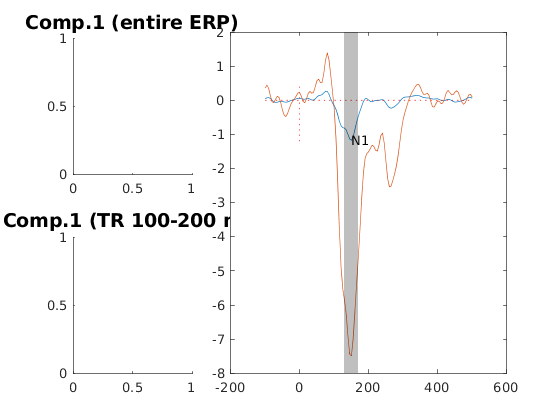

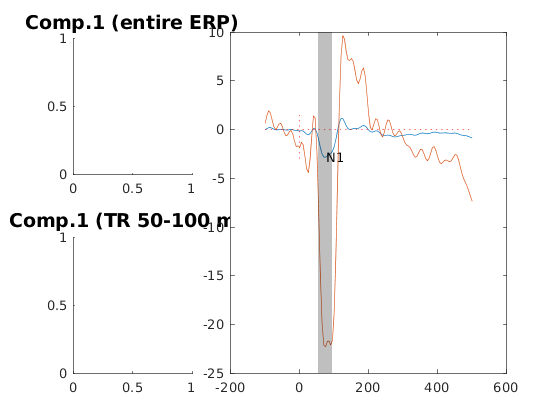

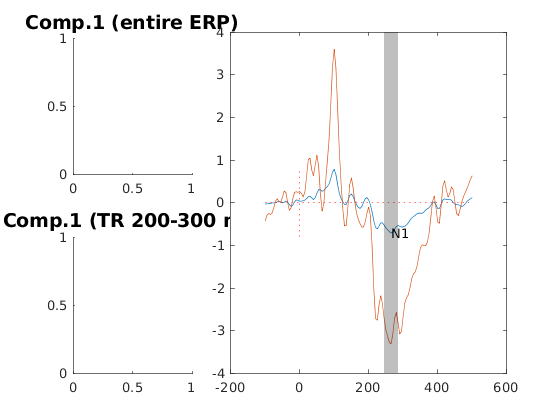

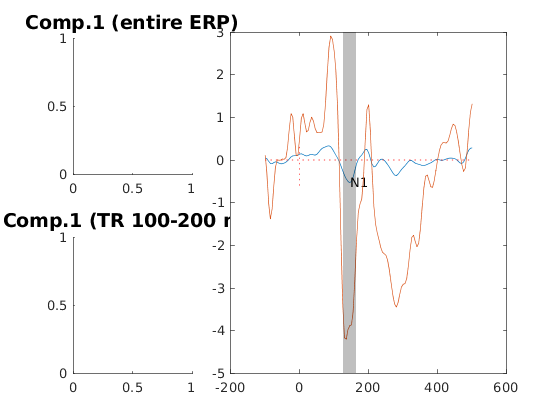

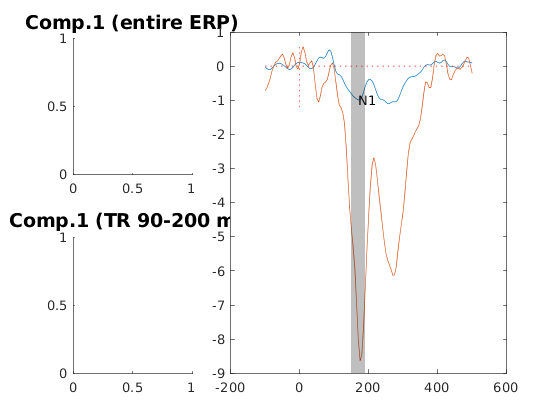

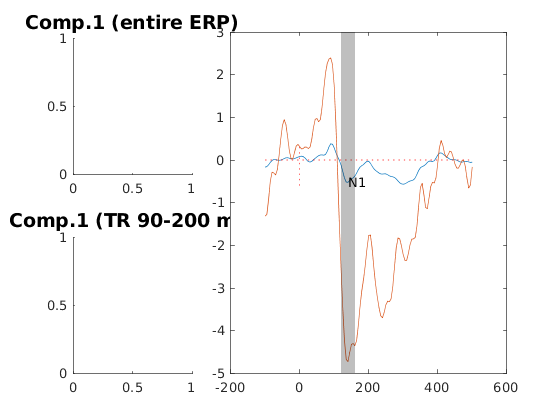

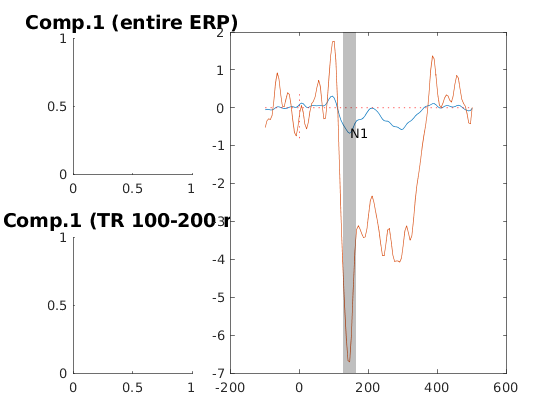

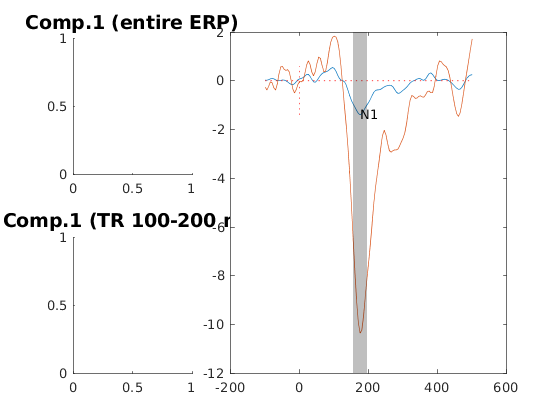

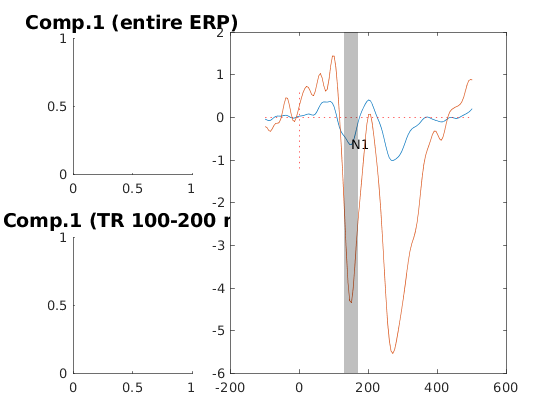

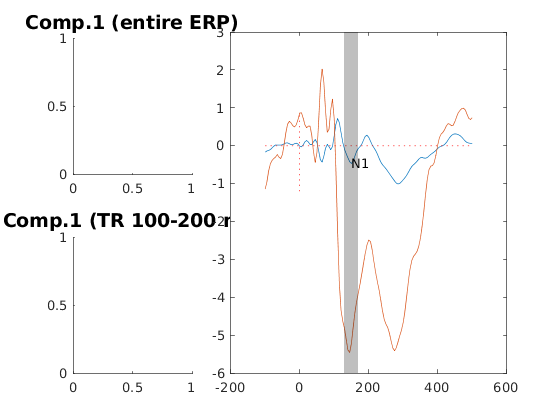

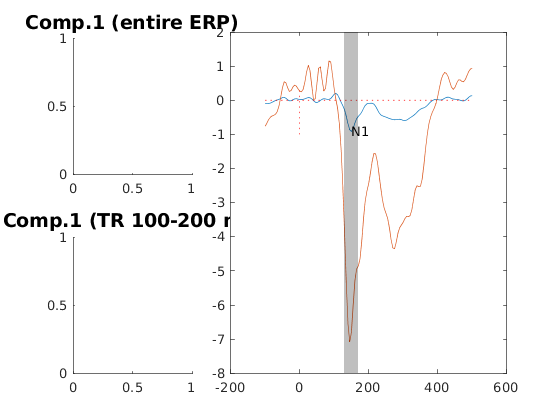

In [10]:
% if you want to project the 63 channels onto component 1 and CREATE CHANNEL 64 (PROJECTION):
clearvars -except EEG a scores lookup_tab

U_m = zeros(11,63,63);
virt_ch = zeros(1, length(EEG.data));

for k = 1:11
    load('TR_mat.mat')
    t = linspace(-100, 500, 121);
    % TR = [90 200];

    tt = unique({EEG.event.dataset});
    tt(1) = [];
    IDx = zeros(11,2);

    for i = 1:11
        disp(tt{i})
        idx = find(strcmp({EEG.event.dataset}, tt(i)));
        IDx(i,1:2) = [min(idx) max(idx)];
    end


    TR = TR_mat(k,:)
    lat = [EEG.event(IDx(k,1):IDx(k,2)).latency];
    X = ERPs_1(EEG, lat);
    X_m = squeeze(mean(X,1));

    [U,S,V] = svd(X_m);
    figure
    subplot(2,3,1)
%     topoplot(U(:,1), EEG.chanlocs,'style','both','electrodes','labelpoint');
    tit = title('Comp.1 (entire ERP)'); tit.FontSize = 14;
    aa = subplot(2,3,[2 3 5 6]);
    plot(t,X_m(17,:)); hline(0); vline(0)
    hold on

    % get the N1 peak latency
    [pks_min, locs_min] = findpeaks(-X_m(17,:), t, 'MinPeakProminence', 0.05);
    pks_min = -pks_min;
    N1_latency = locs_min(locs_min>=TR(1) & locs_min<=TR(2));
    if length(N1_latency) > 1
        idx_x = find(ismember(t, N1_latency));
        val_x = X_m(17,idx_x);
        [~, loc_x] = max(abs(val_x));
        N1_latency = t(idx_x(loc_x));
    end

    text(N1_latency, pks_min(locs_min==N1_latency), 'N1')

    % TR times (40-ms window surrounding the observed peak)
    N1_sample_nos = find(t==N1_latency-20):find(t==N1_latency+20);

    [U,S,V] = svd(X_m(:,N1_sample_nos));
    subplot(2,3,4)
%     topoplot(U(:,1), EEG.chanlocs,'style','both','electrodes','labelpoint');
    tit = title(['Comp.1 (TR ', num2str(TR(1)), '-', num2str(TR(2)), ' ms)']); tit.FontSize = 14;
    back_proj = U(:,1)' * X_m;
    flip_signs = mean(back_proj(N1_sample_nos));
    if flip_signs > 0
        U(:,1) = -U(:,1);
        back_proj = U(:,1)' * X_m;
        subplot(2,3,4)
%         topoplot(U(:,1), EEG.chanlocs,'style','both','electrodes','labelpoint');
        tit = title(['Comp.1 (TR ', num2str(TR(1)), '-', num2str(TR(2)), ' ms)']); tit.FontSize = 14;
    end
    plot(aa, t, back_proj)

    % highlight the N1 range
    axes(aa);
    S = struct;
    S.Vertices = [N1_latency-20 aa.YLim(1); N1_latency-20 aa.YLim(2); N1_latency+20 aa.YLim(2); N1_latency+20 aa.YLim(1)];
    S.Faces = [1 2 3 4];
    S.EdgeColor = 'none';
    S.FaceAlpha = 0.25;
    patch(S)

    U_m(k,:,:) = U;
    virt_ch(lat(1):lat(end)) = U(:,1)' * EEG.data(1:63,lat(1):lat(end));
end

EEG.data(64,:) = virt_ch;